# Denoising Diffusion Probabilistic Model for image generation using Fashion-MNIST

This code implements the diffusion part of Module 3. It contains:
- Loading and analysing the Fashion-MNIST dataset
- Creating the DDPM model with a UNet-backbone (as in original paper)
- Visualizing the forward process (diffusion) and backward process (denoising)
- Construct and train a simple CNN used for feature extraction. This can later be used for FID and KID computation.
- Training the DDPM
- Evaluation of the DDPM with respect to sample-fidelity and stabilty/convergence during training

In [810]:
# Imports

import numpy as np
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import FashionMNIST
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm.auto import tqdm

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
print(f"Torch version {torch.__version__}")


Device: cuda
Torch version 2.3.1+cu118


### Load Fashion-MNIST dataset

In [811]:
ds_fn = FashionMNIST
batch_size = 128

# Scales image to [-1 1] range
transform = Compose([ToTensor(), Lambda(lambda x: x * 2 - 1)])

dataset = ds_fn(root='data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



test_dataset = ds_fn(root='data', train=False, download=True, transform=transform)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

sample, _ = dataset[0]  # this applies the transform
test_sample, _ = test_dataset[0]  # this applies the transform

print(f"Training data is on the pixel range [[{sample.min():.3f}, {sample.max():.3f}]]")
print(f"Test data is on the pixel range [[{test_sample.min():.3f}, {test_sample.max():.3f}]]")

print("Training and test data has been loaded.")

Training data is on the pixel range [[-1.000, 1.000]]
Test data is on the pixel range [[-1.000, 1.000]]
Training and test data has been loaded.


### Analyze dataset

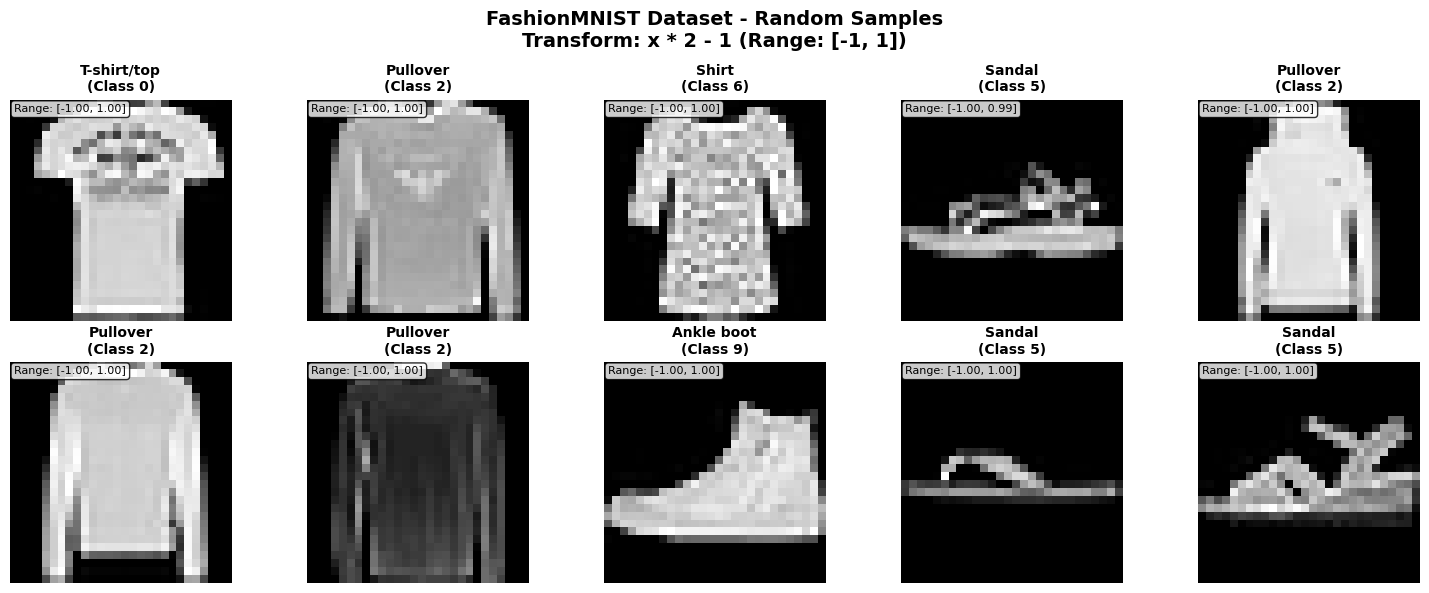

Dataset Statistics:
Total samples: 60000
Number of classes: 10
Image shape: torch.Size([1, 28, 28])
Transform applied: x * 2 - 1
Expected pixel range: [-1, 1]
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Actual pixel range in samples: [-1.000, 1.000]


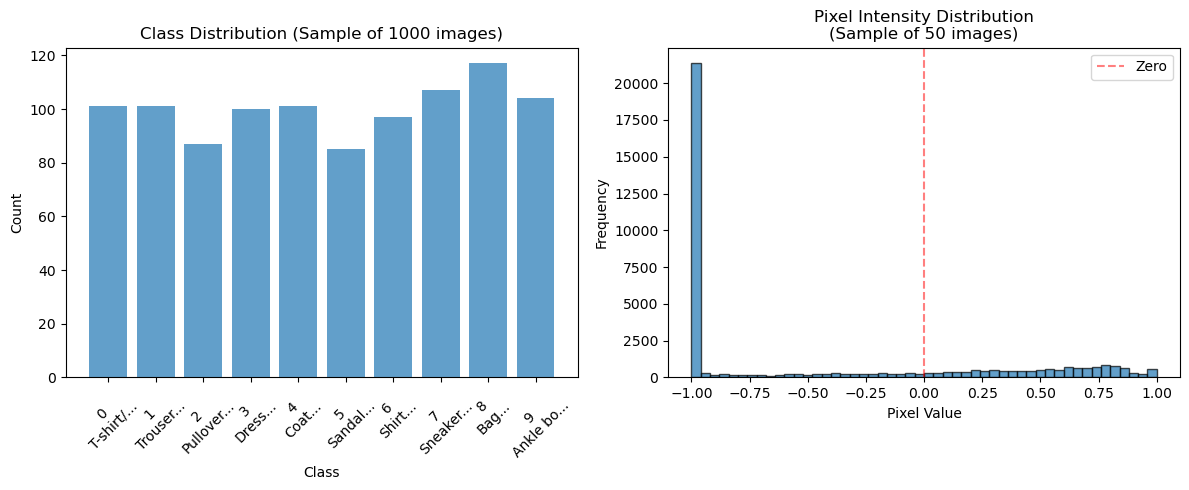

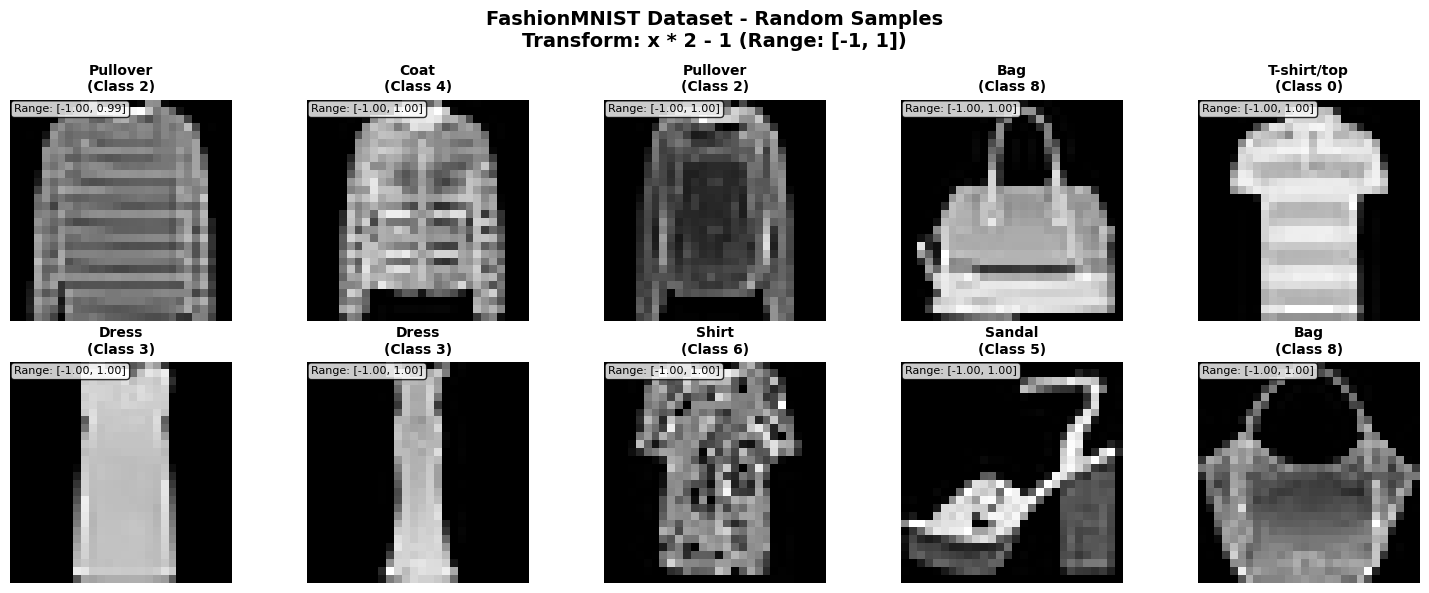

Dataset Statistics:
Total samples: 10000
Number of classes: 10
Image shape: torch.Size([1, 28, 28])
Transform applied: x * 2 - 1
Expected pixel range: [-1, 1]
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Actual pixel range in samples: [-1.000, 1.000]


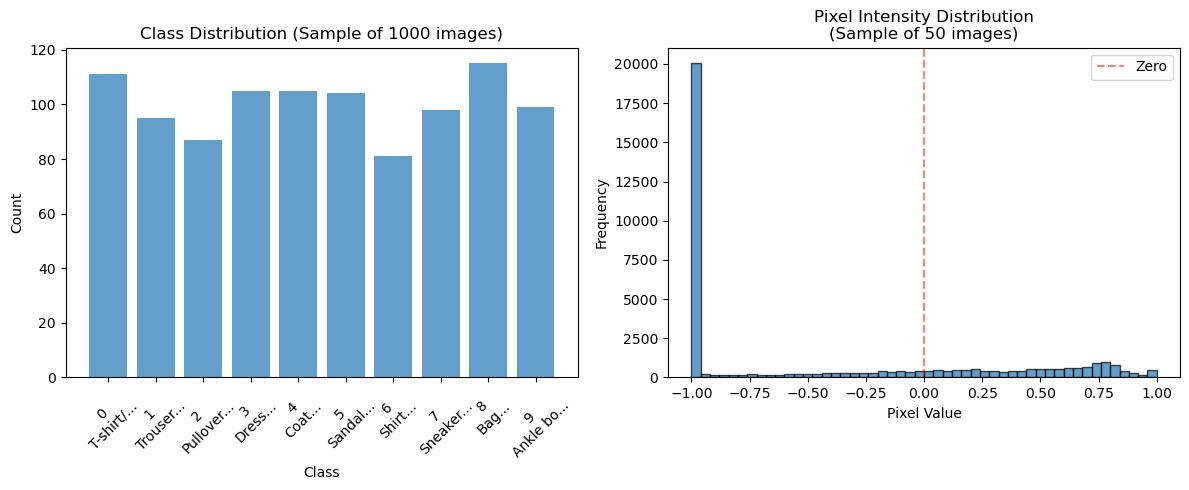

In [812]:
# Visualize dataset

# FashionMNIST class names
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

def visualize_random_samples(dataset, num_samples=10, figsize=(15, 6)):
    """
    Visualize random samples from the FashionMNIST dataset
    """
    # Get random indices
    random_indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    # Create subplot
    fig, axes = plt.subplots(2, 5, figsize=figsize)
    fig.suptitle('FashionMNIST Dataset - Random Samples\nTransform: x * 2 - 1 (Range: [-1, 1])', 
                 fontsize=14, fontweight='bold')
    
    for i, idx in enumerate(random_indices):
        # Get image and label
        image, label = dataset[idx]
        
        # Convert tensor to numpy and squeeze to remove channel dimension
        # Note: image values are in range [-1, 1] due to transform
        img_np = image.squeeze().numpy()
        
        # Calculate subplot position
        row = i // 5
        col = i % 5
        
        # Display image
        axes[row, col].imshow(img_np, cmap='gray')
        axes[row, col].set_title(f'{class_names[label]}\n(Class {label})', 
                                fontsize=10, fontweight='bold')
        axes[row, col].axis('off')
        
        # Add pixel value range info
        axes[row, col].text(0.02, 0.98, f'Range: [{img_np.min():.2f}, {img_np.max():.2f}]',
                           transform=axes[row, col].transAxes, 
                           fontsize=8, verticalalignment='top',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


def analyze_dataset_statistics(dataset):
    """
    Analyze and visualize dataset statistics
    """
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset)}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Image shape: {dataset[0][0].shape}")
    print(f"Transform applied: x * 2 - 1")
    print(f"Expected pixel range: [-1, 1]")
    print(f"Class names: {class_names}")
    
    # Sample a few images to check actual pixel range
    sample_images = [dataset[i][0] for i in range(0, min(100, len(dataset)), 10)]
    min_vals = [img.min().item() for img in sample_images]
    max_vals = [img.max().item() for img in sample_images]
    
    print(f"Actual pixel range in samples: [{min(min_vals):.3f}, {max(max_vals):.3f}]")
    
    # Class distribution (sample 1000 items)
    sample_size = min(1000, len(dataset))
    labels = [dataset[i][1] for i in np.random.choice(len(dataset), sample_size, replace=False)]
    
    plt.figure(figsize=(12, 5))
    
    # Class distribution
    plt.subplot(1, 2, 1)
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts, alpha=0.7)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'Class Distribution (Sample of {sample_size} images)')
    plt.xticks(unique, [f'{i}\n{class_names[i][:8]}...' for i in unique], rotation=45)
    
    # Pixel intensity distribution
    plt.subplot(1, 2, 2)
    sample_pixels = np.concatenate([dataset[i][0].numpy().flatten() 
                                   for i in np.random.choice(len(dataset), 50, replace=False)])
    plt.hist(sample_pixels, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Pixel Intensity Distribution\n(Sample of 50 images)')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Zero')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

visualize_random_samples(dataset, num_samples=10, figsize=(15, 6))
analyze_dataset_statistics(dataset)

visualize_random_samples(test_dataset, num_samples=10, figsize=(15, 6))
analyze_dataset_statistics(test_dataset)

### Construct DDPM

In [813]:
# Create U-Net backbone for the DDPM model (same as in paper)

def sinusoidal_embedding(n, d):
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

class Block(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(Block, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out
    
class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(UNet, self).__init__()

        #sinus embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        #1sthalf
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            Block((1, 28, 28), 1, 10),
            Block((10, 28, 28), 10, 10),
            Block((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            Block((10, 14, 14), 10, 20),
            Block((20, 14, 14), 20, 20),
            Block((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            Block((20, 7, 7), 20, 40),
            Block((40, 7, 7), 40, 40),
            Block((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        #bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            Block((40, 3, 3), 40, 20),
            Block((20, 3, 3), 20, 20),
            Block((20, 3, 3), 20, 40)
        )

        #2ndhalf
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            Block((80, 7, 7), 80, 40),
            Block((40, 7, 7), 40, 20),
            Block((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            Block((40, 14, 14), 40, 20),
            Block((20, 14, 14), 20, 10),
            Block((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            Block((20, 28, 28), 20, 10),
            Block((10, 28, 28), 10, 10),
            Block((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [814]:
# Create DDPM model

class DDPM(nn.Module):
    def __init__(self, network, timesteps=1000, min_beta=1e-4, max_beta=0.02, device='cpu'):
        super(DDPM, self).__init__()
        self.network = network.to(device)
        self.timesteps = timesteps
        self.device = device
        
        # Create beta schedule
        self.betas = torch.linspace(min_beta, max_beta, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)


    def forward(self, x0, t, noise=None):
        """Forward pass through the DDPM model.
        :param x0: Input tensor (batch_size, channels, height, width)
        :param t: Time step tensor (batch_size,)
        :return: Output tensor after applying noise
        """

        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if noise is None:
            noise = torch.randn(n, c, h, w).to(self.device)

        # Apply noise (Algorithm 1 in DDPM paper)
        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * noise

        return noisy
    
    def backward(self, x, t):
        """
        Backward pass through the DDPM model.
        :param x: Input tensor (batch_size, channels, height, width)
        :param t: Time step tensor (batch_size,)
        :return: Output tensor after applying the network
        """
        return self.network(x, t)
    
    def sample(self, n_samples, device, image_size=(1, 28, 28)):
        """
        Generate samples from the model using the reverse diffusion process.
        :param n_samples: Number of samples to generate
        :param device: Device to run sampling on
        :param image_size: Shape of each generated sample (C, H, W)
        :return: Generated images tensor in [-1, 1] range
        """
        self.eval()
        with torch.no_grad():

            x = torch.randn(n_samples, *image_size).to(device)

            for t in reversed(range(self.timesteps)):
                
                t_tensor = torch.full((n_samples, 1), t, device=device, dtype=torch.long)

                if t > 0:  # Don't process t=0

                    noisy_prediction = self.backward(x, t_tensor)
                    
                    alpha_t = self.alphas[t]
                    alpha_t_bar = self.alpha_bars[t]
                    
                    z = torch.randn_like(x)
                    beta_t = self.betas[t]
                    sigma_t = beta_t.sqrt()

                    # Algorithm 2 in paper
                    x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * noisy_prediction) + sigma_t * z


                if t == 0:

                    noisy_prediction = self.backward(x, t_tensor)
                    
                    alpha_t = self.alphas[t]
                    alpha_t_bar = self.alpha_bars[t]
                    
                    z = 0.0  # No noise at t=0
                    beta_t = self.betas[t]
                    sigma_t = beta_t.sqrt()

                    # Algorithm 2 in paper
                    x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * noisy_prediction) + sigma_t * z
        
        # Transform from arbitrary range → [-1, 1]
        x_min = x.amin(dim=[1, 2, 3], keepdim=True)
        x_max = x.amax(dim=[1, 2, 3], keepdim=True)
        x = 2 * (x - x_min) / (x_max - x_min + 1e-8) - 1
                
        return x
        

In [815]:
# Set hyperparameters for DDPM
timesteps = 1000
min_beta = 1e-4
max_beta = 0.02
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create DDPM
ddpm = DDPM(network=UNet(n_steps=timesteps),
            timesteps=timesteps,
            min_beta=min_beta,
            max_beta=max_beta,
            device=device)

### Showcase forward and backward process (Diffusion and denosing)

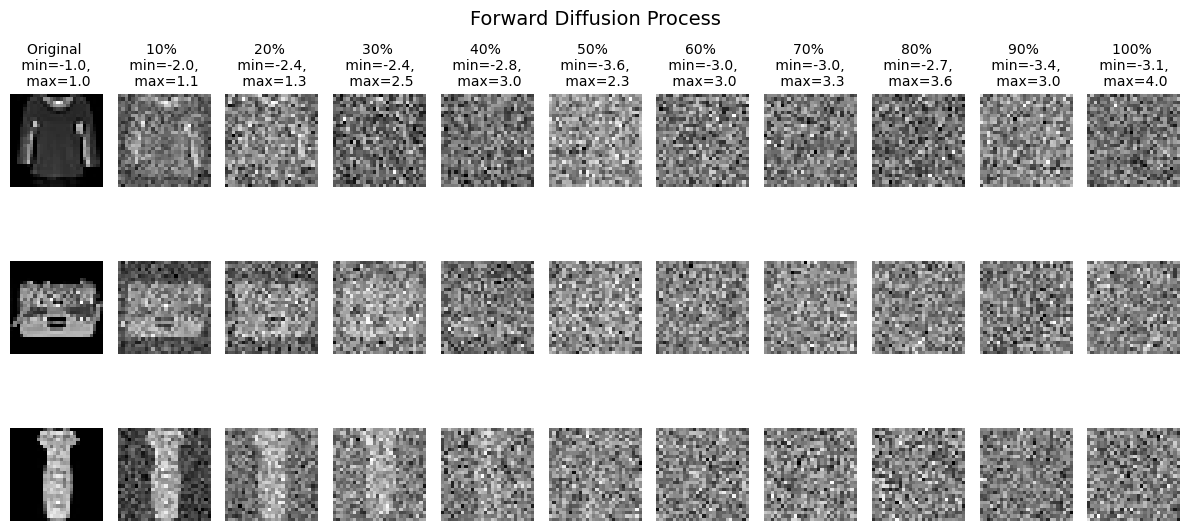

In [824]:
def show_forward_compact(ddpm, dataloader, device, n_images=6):
    """
    Visualize the forward diffusion process of the DDPM model.
    :param ddpm: The DDPM model instance.
    :param dataloader: DataLoader for the dataset.
    :param device: Device to run the model on (CPU or GPU).
    :param n_images: Number of images to visualize.
    """
    # Get a batch of images
    for batch in dataloader:
        imgs = batch[0][:n_images]
        break
    
    noise_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    n_cols = 1 + len(noise_percentages)
    
    fig, axes = plt.subplots(n_images, n_cols, figsize=(12, 2 * n_images))
    
    if n_images == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_images):
        # Original
        original_img = imgs[i].detach().cpu().numpy() if isinstance(imgs, torch.Tensor) else imgs[i]
        axes[i, 0].imshow(original_img[0], cmap='gray')
        axes[i, 0].set_title(f'Original \n min={original_img.min():.1f}, \n max={original_img.max():.1f}' if i == 0 else '', fontsize=10)
        axes[i, 0].axis('off')
        
        # Noisy versions
        for j, percent in enumerate(noise_percentages):
            timestep = int(percent * ddpm.timesteps) - 1
            noisy_img = ddpm(imgs[i:i+1].to(device), [timestep])
            noisy_img = noisy_img.detach().cpu().numpy() if isinstance(noisy_img, torch.Tensor) else noisy_img
            
            axes[i, j+1].imshow(noisy_img[0][0], cmap='gray')
            if i == 0:  # Only show titles on first row
                axes[i, j+1].set_title(f'{int(percent * 100)}% \n min={noisy_img.min():.1f}, \n max={noisy_img.max():.1f}', fontsize=10)
            axes[i, j+1].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Forward Diffusion Process', fontsize=14)
    plt.show()

show_forward_compact(ddpm, dataloader, device, n_images=3)

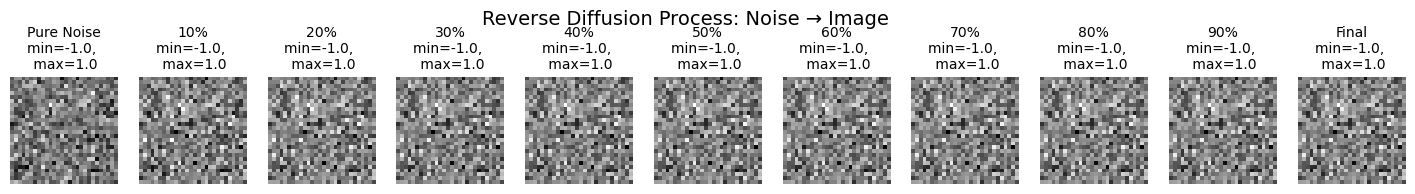

In [825]:
# Visualisze the reverse diffusion process (denoising) with the untrained DDPM model

def show_reverse_compact(ddpm, device, n_images=6, image_chw=(1, 28, 28)):
    """
    Visualize the reverse diffusion process of the DDPM model (denoising).
    Uses the same denoising logic as the working generate_new_images function.
    """
    
    # Define which timesteps to visualize (but still process all timesteps)
    noise_percentages = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]                   
    reversed_list = noise_percentages[::-1]
    timesteps_to_show = [int(p * ddpm.timesteps) for p in noise_percentages]
    timesteps_to_show = [min(t, ddpm.timesteps-1) for t in timesteps_to_show]  # Clamp to valid range
    
    n_cols = len(timesteps_to_show)
    
    fig, axes = plt.subplots(n_images, n_cols, figsize=(18, 2.5 * n_images))
    
    if n_images == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_images):
        
        # Start with pure random noise
        c, h, w = image_chw
        x = torch.randn(1, c, h, w).to(device)
        
        # Store images at visualization timesteps
        saved_images = {}
        
        with torch.no_grad():

            for t in range(ddpm.timesteps-1, -1, -1):  # Go from T-1 to 0 (or T to 1 in paper)
                
                # Save image if this timestep should be visualized
                if t in timesteps_to_show:
                    saved_images[t] = x.clone()
                
                # Perform denoising step

                if t > 0:  # Don't process t=0

                    time_tensor = (torch.ones(1, 1) * t).to(device).long()
                    noisy_prediction = ddpm.backward(x, time_tensor)
                    
                    alpha_t = ddpm.alphas[t]
                    alpha_t_bar = ddpm.alpha_bars[t]
                    
                    z = torch.randn_like(x)
                    beta_t = ddpm.betas[t]
                    sigma_t = beta_t.sqrt()

                    # Algorithm 2 in paper
                    x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * noisy_prediction) + sigma_t * z


                if t == 0:
                    time_tensor = (torch.ones(1, 1) * t).to(device).long()
                    noisy_prediction = ddpm.backward(x, time_tensor)
                    
                    alpha_t = ddpm.alphas[t]
                    alpha_t_bar = ddpm.alpha_bars[t]
                    
                    z = 0.0  # No noise at t=0
                    beta_t = ddpm.betas[t]
                    sigma_t = beta_t.sqrt()

                    # Algorithm 2 in paper
                    x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * noisy_prediction) + sigma_t * z


        # Save final result (t=0)
        saved_images[0] = x.clone()

        # Display saved images
        for col_idx, t in enumerate(timesteps_to_show):
            if t in saved_images:
                img = saved_images[t].detach().cpu().squeeze(0)
                img = 2 * (img - img.min()) / (img.max() - img.min() + 1e-8) - 1
                img = img.numpy()
            else:
                img = np.zeros((h, w))

            axes[i, col_idx].imshow(img[0], cmap='gray', vmin=-1, vmax=1)

            if i == 0:
                if t == ddpm.timesteps - 1:
                    axes[i, col_idx].set_title(
                        f'Pure Noise\nmin={img[0].min():.1f}, \n max={img[0].max():.1f}',
                        fontsize=10
                    )
                elif t == 0:
                    axes[i, col_idx].set_title(
                        f'Final\nmin={img[0].min():.1f}, \n max={img[0].max():.1f}',
                        fontsize=10
                    )
                else:
                    percentage = reversed_list[col_idx] * 100
                    axes[i, col_idx].set_title(
                        f'{percentage:.0f}%\nmin={img[0].min():.1f}, \n max={img[0].max():.1f}',
                        fontsize=10
                    )
            axes[i, col_idx].axis('off')
    
    #plt.tight_layout()
    plt.suptitle('Reverse Diffusion Process: Noise → Image', fontsize=14)
    plt.show()

null_model = DDPM(UNet(n_steps=timesteps), timesteps=timesteps, device=device)

show_reverse_compact(null_model, device, n_images=1)

### Construct and train FeatureExtractor (Simple CNN)

In [818]:

import torch.nn.functional as F
from scipy import linalg

# ---------------------------
# Feature Extractor + Classifier Head
# ---------------------------
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)  # penultimate layer
        self.fc2 = nn.Linear(128, 10)    # classification head

    def forward(self, x, return_features=False):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.adaptive_avg_pool2d(x, (12, 12))
        x = torch.flatten(x, 1)
        features = self.fc1(x)
        if return_features:
            return features
        features = F.relu(self.fc1(x))
        out = self.fc2(features)
        return out
    

def compute_fid(real_images, fake_images, feature_extractor, device, batch_size=128):
    feature_extractor.eval()

    def extract_features(images):
        feats = []
        with torch.no_grad():
            for i in range(0, len(images), batch_size):
                batch = images[i:i+batch_size].to(device)
                
                batch = torch.clamp(batch, -1, 1)  # ensure same pixel range

                batch_feats = feature_extractor(batch, return_features=True)
                feats.append(batch_feats.cpu())
        return torch.cat(feats, dim=0).numpy()

    real_feats = extract_features(real_images)
    fake_feats = extract_features(fake_images)

    mu_real, sigma_real = np.mean(real_feats, axis=0), np.cov(real_feats, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_feats, axis=0), np.cov(fake_feats, rowvar=False)

    diff = mu_real - mu_fake
    covmean, _ = linalg.sqrtm(sigma_real @ sigma_fake, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid



In [819]:

retrain_feature_extractor = False


if retrain_feature_extractor:
    print("Retraining feature extractor...")
    # ---------------------------
    # Training Loop for Feature Extractor
    # ---------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FeatureExtractor().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    num_epochs = 10
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)  # classification mode
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(dataloader.dataset)
        train_acc = 100.0 * correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(testloader, desc=f"Epoch {epoch+1}/{num_epochs} - Test"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(testloader.dataset)
        val_acc = 100.0 * val_correct / val_total

        print(f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # ---------------------------
    # Save model weights
    # ---------------------------
    torch.save(model.state_dict(), "feature_extractor_fashionmnist.pth")
    print("Feature extractor trained and saved to 'feature_extractor_fashionmnist.pth'")

### Training loop and util functions for loading images and computing metrics

In [ ]:
from torchvision import transforms
from PIL import Image
import os

def load_generated_images(folder, device="cpu"):
    """
    Loads all PNG images from a folder into a single tensor with shape [N, 1, H, W].

    Args:
        folder: Path to the folder with PNG files.
        device: Torch device to load tensors to.

    Returns:
        torch.Tensor of shape [N, 1, H, W] in range [-1, 1]
    """
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),   # force 1 channel
        transforms.ToTensor(),                         # [0, 1], shape [1, H, W]
        transforms.Lambda(lambda t: t * 2 - 1)          # scale to [-1, 1]
    ])

    files = sorted(os.listdir(folder))
    imgs = [
        transform(Image.open(os.path.join(folder, f))).to(device)
        for f in files if f.lower().endswith(".png")
    ]
    return torch.stack(imgs)

In [ ]:
import time 
 
def compute_fid_score(ddpm, testloader, feature_extractor, device, n_show=0, use_pre_generated=False):
    """
    Compute FID score.
    """
    start_time = time.time()
    ddpm.eval()
    num_eval_samples = 10000
    fake_images = []
    
    if use_pre_generated:
        print("Loading pre-generated images...")
        fake_images = load_generated_images("generated_fmnist", device=device)
        print(f"Loaded {len(fake_images)} pre-generated images.")
    else:
        # Testing by comparing test with generated data (Fake)
        with torch.no_grad():
            for _ in range(num_eval_samples // 100):  # generate in chunks
                fake_images.append(ddpm.sample(100, device))
        fake_images = torch.cat(fake_images, dim=0)

    print("Generated fake images:")
    print(f" Pixel range min: {fake_images[0].min()}, max: {fake_images[0].max()}")
    print("Shape: ", fake_images[0].shape)
    print(f"Generated {fake_images.size(0)} fake images.")

    # Get real samples from test set
    real_images = []
    for batch in testloader:
        real_images.append(batch[0])
        if len(real_images) * batch[0].size(0) >= num_eval_samples:
            break
    real_images = torch.cat(real_images, dim=0)[:num_eval_samples]

    print("Real images:")
    print(f" Pixel range min: {real_images[0].min()}, max: {real_images[0].max()}")
    print("Shape: ", real_images[0].shape)
    print(f"Generated {real_images.size(0)} real images.")

    if n_show > 0:
        # Visualization
        fig, axes = plt.subplots(2, n_show, figsize=(2*n_show, 4))
        for i in range(n_show):
            # Fake image
            axes[0, i].imshow(fake_images[i].cpu().squeeze(0), cmap="gray", vmin=-1, vmax=1)
            axes[0, i].axis("off")
            if i == 0:
                axes[0, i].set_title("Fake", fontsize=12)

            # Real image
            axes[1, i].imshow(real_images[i].cpu().squeeze(0), cmap="gray", vmin=-1, vmax=1)
            axes[1, i].axis("off")
            if i == 0:
                axes[1, i].set_title("Real", fontsize=12)

        plt.suptitle("Generated (Top) vs Real (Bottom) Samples", fontsize=14)
        plt.show()

    # Put them on the same device
    real_images = real_images.to(device)
    fake_images = fake_images.to(device)

    print("Real stats:", real_images.min().item(), real_images.max().item(), real_images.mean().item())
    print("Fake stats:", fake_images.min().item(), fake_images.max().item(), fake_images.mean().item())

    fid = compute_fid(real_images, fake_images, feature_extractor, device, batch_size=128)
    end = time.time()
    print(f"Elapsed time for FID computation: {end - start_time:.2f} seconds")

    return fid 



In [821]:
# Time to train the model on the data so it can generate more good looking images

def training_loop(ddpm, dataloader, testloader, num_epochs, optim, device, weights_path):
    """
    Training loop for the DDPM model.
    :param ddpm: The DDPM model instance.
    :param loader: DataLoader for the dataset.
    :param num_epochs: Number of epochs to train.
    :param optim: Optimizer for training.
    :param device: Device to run the model on (CPU or GPU).
    :param weights_path: Path to save the model weights.
    """

    loss_fn = nn.MSELoss()
    best_loss = float('inf')
    timesteps = ddpm.timesteps
    
    # Stability and convergence tracking
    train_losses = []
    grad_norms = []
    param_change_rates = []
    fid_scores = []

    prev_params = None  # For parameter change tracking
    feature_extractor = FeatureExtractor().to(device)
    feature_extractor.load_state_dict(torch.load("feature_extractor_fashionmnist.pth", map_location=device))


    for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
        
        epoch_loss = 0.0
        batch_grad_norms = []


        for step, batch in enumerate(tqdm(dataloader, leave=False, desc=f"Epoch {epoch + 1}/{num_epochs}")):

            x0 = batch[0].to(device)  # Get images from the batch
            n = len(x0)

            noise = torch.randn_like(x0).to(device)

            t = torch.randint(0, timesteps, (n,)).to(device)

            # Forward pass through the DDPM model
            x_noisy = ddpm(x0, t, noise)

            # Get model prediction of noise
            predicted_noise = ddpm.backward(x_noisy, t.reshape(n, -1))

            # Compuate loss
            loss = loss_fn(predicted_noise, noise)
    
            # Backward pass and optimization
            optim.zero_grad()
            loss.backward()

            # Gradient L2 norm tracking
            total_norm = 0.0
            for p in ddpm.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            batch_grad_norms.append(total_norm)

            optim.step()  

            # Update epoch loss after each batch
            epoch_loss += loss.item() * len(x0) / len(dataloader.dataset)

        # Average grad norm for this epoch
        grad_norms.append(sum(batch_grad_norms) / len(batch_grad_norms))

        # Parameter change rate tracking
        if prev_params is not None:
            change_norm = 0.0
            for p, prev_p in zip(ddpm.parameters(), prev_params):
                change_norm += torch.norm(p.data - prev_p).item() ** 2
            change_norm = change_norm ** 0.5
            param_change_rates.append(change_norm)
        else:
            param_change_rates.append(0.0)

        # Save current params for next iteration
        prev_params = [p.clone().detach() for p in ddpm.parameters()]


        # Save best model so far
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), weights_path)
            print(f"Epoch {epoch + 1}/{num_epochs} - New best loss: {best_loss:.4f} - Weights saved to {weights_path}")
        
        train_losses.append(epoch_loss)

        # Can be computed every 5 epoch or so
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            pass
            #fid_scores.append(compute_fid_score(ddpm, testloader, feature_extractor, device, n_show = 0))

    return ddpm, train_losses, grad_norms, param_change_rates, fid_scores


### Train DDPM

In [828]:
# Train the DDPM model

# Hyperparamters for traning
weights_path = 'weights/weights.pth'
num_epochs = 100
learning_rate = 1e-3

# Traning loop
model, train_losses, grad_norms, param_change_rates, fid_scores = training_loop(ddpm, dataloader, testloader, num_epochs, Adam(ddpm.parameters(), lr=learning_rate), device, weights_path)

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Evaluate DDPM

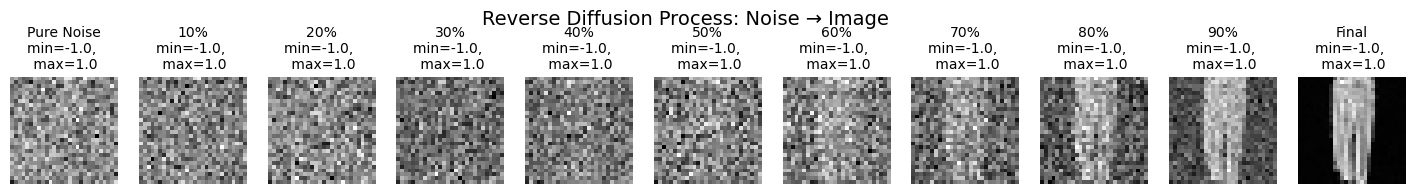

In [829]:

# Evaluate the best model by showing n_images generation sequence
best_model = DDPM(UNet(n_steps=timesteps), timesteps=timesteps, device=device)
weights_path = 'weights/weights_100epoch.pth'
best_model.load_state_dict(torch.load(weights_path, map_location=device))
best_model.eval()
show_reverse_compact(best_model, device, n_images=1)

In [ ]:
import os
import torch
from torchvision.utils import save_image

def generate_and_save_images(model, device, N, save_dir="generated_images", batch_size=100, overwrite=False):
    """
    Generates N images from a DDPM model and saves them as PNG files.

    Args:
        model: The trained DDPM model with a `.sample(batch_size, device)` method.
        device: Torch device (e.g., 'cuda' or 'cpu').
        N: Total number of images to generate.
        save_dir: Directory to save PNG files.
        batch_size: Number of images per generation batch.
        overwrite: If True, regenerates even if files exist.
    """
    os.makedirs(save_dir, exist_ok=True)

    existing = len(os.listdir(save_dir))
    if existing >= N and not overwrite:
        print(f"[INFO] Found {existing} existing images in '{save_dir}'. Skipping generation.")
        return

    model.eval()
    idx = 0
    with torch.no_grad():
        for _ in range((N + batch_size - 1) // batch_size):
            current_batch_size = min(batch_size, N - idx)
            imgs = model.sample(current_batch_size, device)  # [B, C, H, W]
            for i in range(current_batch_size):
               img = (imgs[i] + 1) / 2 #Scale from [-1, 1] to [0, 1]
               save_image(img, os.path.join(save_dir, f"{idx + i:05d}.png"))
            idx += current_batch_size
            print(f"[INFO] Saved {idx}/{N} images...")

    print(f"[DONE] Generated and saved {N} images in '{save_dir}'.")

best_model = DDPM(UNet(n_steps=timesteps), timesteps=timesteps, device=device)
weights_path = 'weights/weights_100epoch.pth'
best_model.load_state_dict(torch.load(weights_path, map_location=device))
best_model.eval()
generate_and_save_images(best_model, device, N=10_000, save_dir="generated_fmnist", batch_size=100)

[INFO] Found 10000 existing images in 'generated_fmnist'. Skipping generation.


Loading pre-generated images...
Loaded 10000 pre-generated images.
Generated fake images:
 Pixel range min: -1.0, max: 1.0
Shape:  torch.Size([1, 28, 28])
Generated 10000 fake images.
Real images:
 Pixel range min: -1.0, max: 1.0
Shape:  torch.Size([1, 28, 28])
Generated 10000 real images.


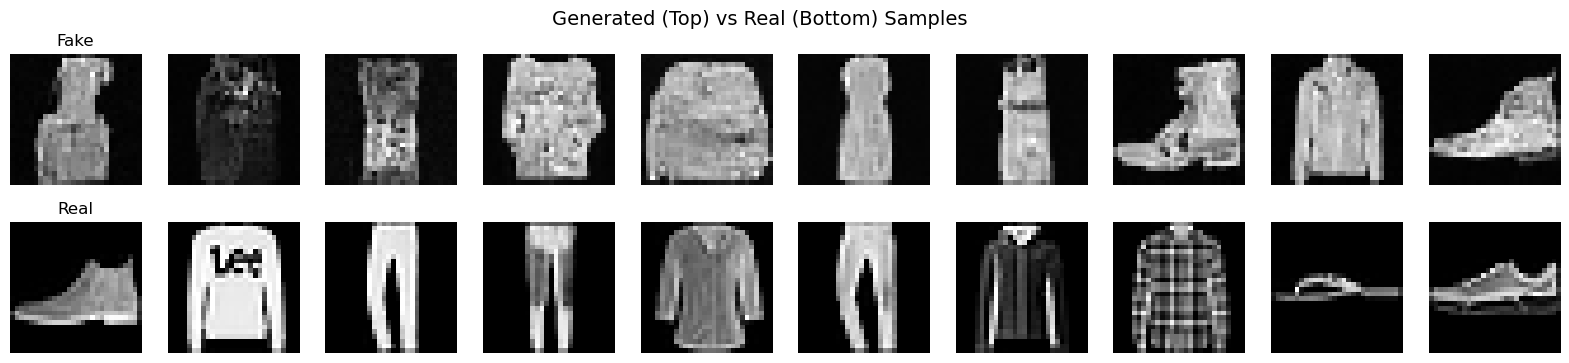

Real stats: -1.0 1.0 -0.42630138993263245
Fake stats: -1.0 1.0 -0.3949229419231415
Elapsed time for FID computation: 3.73 seconds
Final FID score: 307.9352


In [ ]:
# Compute fid score on best model using feature extractor and train/test datasets
best_model = DDPM(UNet(n_steps=timesteps), timesteps=timesteps, device=device)
weights_path = 'weights/weights_100epoch.pth'
best_model.load_state_dict(torch.load(weights_path, map_location=device))
best_model.eval()

feature_extractor = FeatureExtractor().to(device)
feature_extractor.load_state_dict(torch.load("feature_extractor_fashionmnist.pth", map_location=device))

# Alter this function load in the 10k images from the generated_fmnist folder
fid_score = compute_fid_score(best_model, testloader, feature_extractor, device, n_show = 10, use_pre_generated=True)
print(f"Final FID score: {fid_score:.4f}")

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader

# -------------------
# Config
# -------------------
self_compare = False  # True = compare train data to itself, False = real vs fake

# -------------------
# Load feature extractor
# -------------------
feature_extractor = FeatureExtractor().to(device)
feature_extractor.load_state_dict(
    torch.load("feature_extractor_fashionmnist.pth", map_location=device)
)
feature_extractor.eval()

# If not self-compare, load fake images
if not self_compare:
    fake_images = load_generated_images("generated_fmnist", device=device)
    print(fake_images.shape)  # -> torch.Size([N, 1, 28, 28])
    print(f"Pixel range min: {fake_images.min().item()}, max: {fake_images.max().item()}")

# -------------------
# Feature extraction helper
# -------------------
def get_features(loader):
    feats = []
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (list, tuple)):  # (images, labels)
                imgs = batch[0]
            else:  # tensor only
                imgs = batch
            imgs = imgs.to(device)  # already in [-1, 1]
            f = feature_extractor(imgs, return_features=True)
            feats.append(f.cpu())
    return torch.cat(feats, dim=0)

# -------------------
# Prepare features
# -------------------
if self_compare:
    real_loader_1 = DataLoader(dataset, batch_size=128, shuffle=False)
    real_loader_2 = DataLoader(test_dataset, batch_size=128, shuffle=False)
    real_feats = get_features(real_loader_1)
    fake_feats = get_features(real_loader_2)  # just another copy of train data
else:
    real_loader = DataLoader(dataset, batch_size=128, shuffle=False)
    real_feats = get_features(real_loader)
    fake_loader = DataLoader(fake_images, batch_size=128, shuffle=False)
    fake_feats = get_features(fake_loader)

print(f"Real features shape: {real_feats.shape}")
print(f"Fake features shape: {fake_feats.shape}")

# -------------------
# KID computation
# -------------------
def compute_kid(real_feats, fake_feats, num_splits=10):
    """Unbiased KID (polynomial kernel, degree 3, bias 1)."""
    m = real_feats.size(0)
    n = fake_feats.size(0)
    d = real_feats.size(1)

    kid_scores = []
    for _ in range(num_splits):
        real_idx = torch.randperm(m)[:min(m, n)]
        fake_idx = torch.randperm(n)[:min(m, n)]
        r = real_feats[real_idx]
        f = fake_feats[fake_idx]

        k_rr = (r @ r.T / d + 1) ** 3
        k_ff = (f @ f.T / d + 1) ** 3
        k_rf = (r @ f.T / d + 1) ** 3

        score = (
            (k_rr.sum() - k_rr.trace()) / (r.shape[0] * (r.shape[0] - 1))
            + (k_ff.sum() - k_ff.trace()) / (f.shape[0] * (f.shape[0] - 1))
            - 2 * k_rf.mean()
        )
        kid_scores.append(score.item())

    kid_scores = np.array(kid_scores)
    mean_kid = kid_scores.mean()
    ci95 = 1.96 * kid_scores.std(ddof=1) / np.sqrt(num_splits)
    return mean_kid, ci95

# -------------------
# Run
# -------------------
mean_kid, ci95 = compute_kid(real_feats, fake_feats, num_splits=10)
print(f"KID (mean ± 95% CI): {mean_kid:.6f} ± {ci95:.6f}")



torch.Size([10000, 1, 28, 28])
Pixel range min: -1.0, max: 1.0
Real features shape: torch.Size([60000, 128])
Fake features shape: torch.Size([10000, 128])
KID (mean ± 95% CI): 4360.601953 ± 171.056888


Generated 10 fake images.


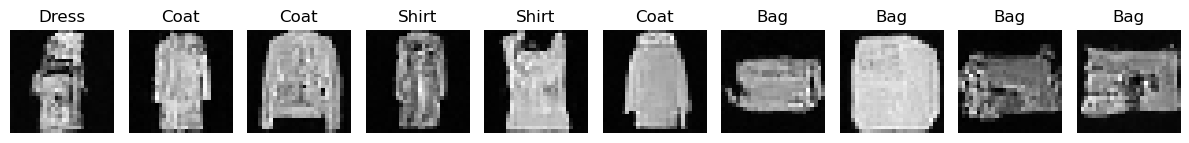

In [ ]:
# Test the classifier on a few generated images to check if it can classify them correctly (and to check that the generated images looks reasonable)

import torch
import matplotlib.pyplot as plt
import random

# Parameters
num_eval_samples = 10   # total fake images to generate
batch_size = 10          # generation batch size
num_visualize = 10        # how many to show

# --- 1. Generate fake images ---
best_model = DDPM(UNet(n_steps=timesteps), timesteps=timesteps, device=device)
weights_path = 'weights/weights_100epoch.pth'
best_model.load_state_dict(torch.load(weights_path, map_location=device))
best_model.eval()

best_model.eval()
fake_images = []
with torch.no_grad():
    for _ in range(num_eval_samples // batch_size):
        fake_images.append(best_model.sample(batch_size, device))
fake_images = torch.cat(fake_images, dim=0)

print(f"Generated {fake_images.size(0)} fake images.")

# --- 2. Load trained feature extractor ---
model = FeatureExtractor().to(device)
model.load_state_dict(torch.load("feature_extractor_fashionmnist.pth", map_location=device))
model.eval()

# --- 3. Classify fake images ---
with torch.no_grad():
    outputs = model(fake_images.to(device))
    _, predicted = outputs.max(1)
predicted = predicted.cpu()

# --- 4. Visualize N random images with predictions ---
# Map FashionMNIST class IDs to names
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Pick random indexes to visualize
indices = random.sample(range(fake_images.size(0)), num_visualize)

plt.figure(figsize=(12, 4))
for i, idx in enumerate(indices):
    img = fake_images[idx].cpu()
    if img.shape[0] == 1:  # grayscale
        img = img.squeeze(0)
        cmap = "gray"
    else:
        img = img.permute(1, 2, 0)
        cmap = None

    plt.subplot(1, num_visualize, i + 1)
    plt.imshow(img, cmap=cmap)
    plt.title(class_names[predicted[idx]])
    plt.axis("off")

plt.tight_layout()
plt.show()


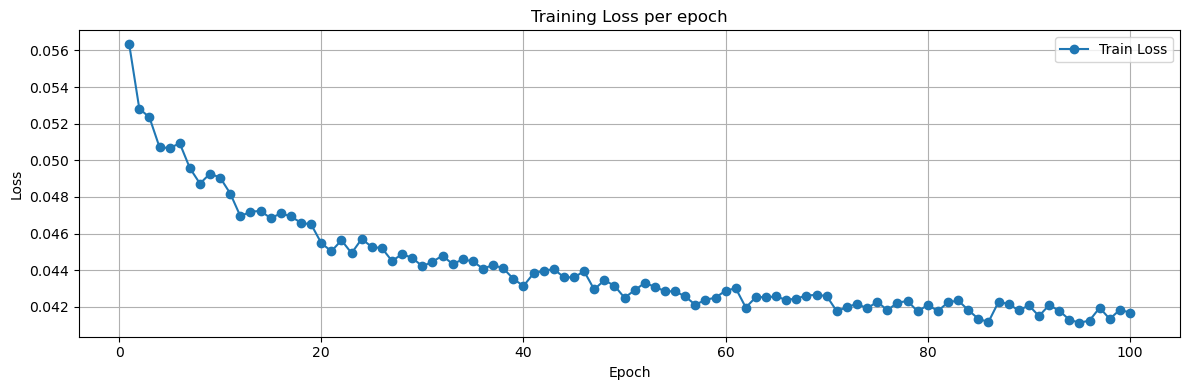

In [ ]:
epoches = list(range(1, num_epochs + 1))

# Training loss
plt.figure(figsize=(12, 4))  # width=12, height=4
plt.plot(epoches, train_losses, label="Train Loss", marker ='o')
plt.title("Training Loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

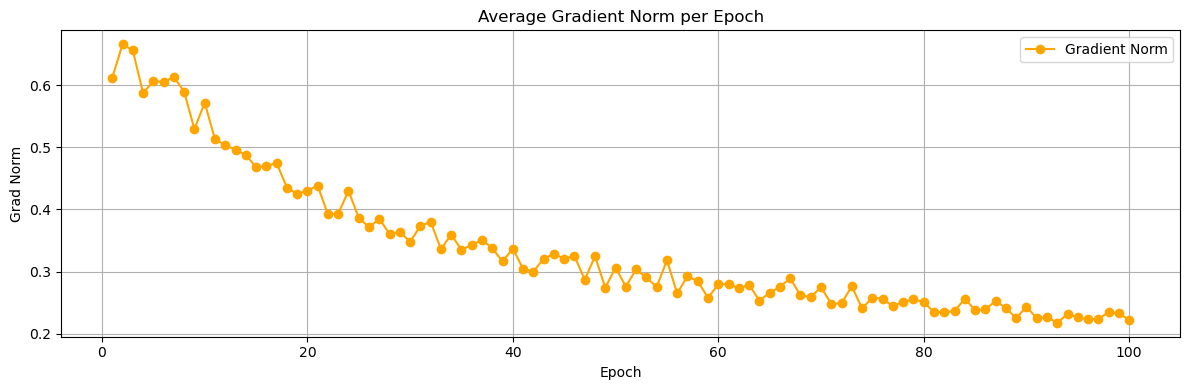

In [ ]:
epochs = list(range(1, num_epochs + 1))
  
# Gradient Norm
plt.figure(figsize=(12, 4))  # width=12, height=4
plt.plot(epochs, grad_norms, label="Gradient Norm", color='orange', marker='o')
plt.title("Average Gradient Norm per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Grad Norm")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

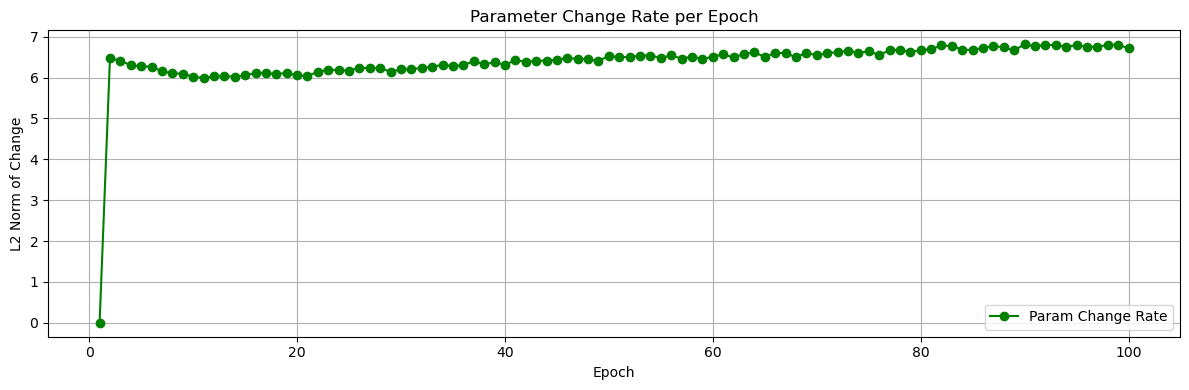

In [ ]:
epochs = list(range(1, num_epochs + 1))
    
# Parameter Change Rate
plt.figure(figsize=(12, 4))  # width=12, height=4

# Parameter Change Rate
plt.plot(epochs, param_change_rates, label="Param Change Rate", color='green', marker='o')
plt.title("Parameter Change Rate per Epoch")
plt.xlabel("Epoch")
plt.ylabel("L2 Norm of Change")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

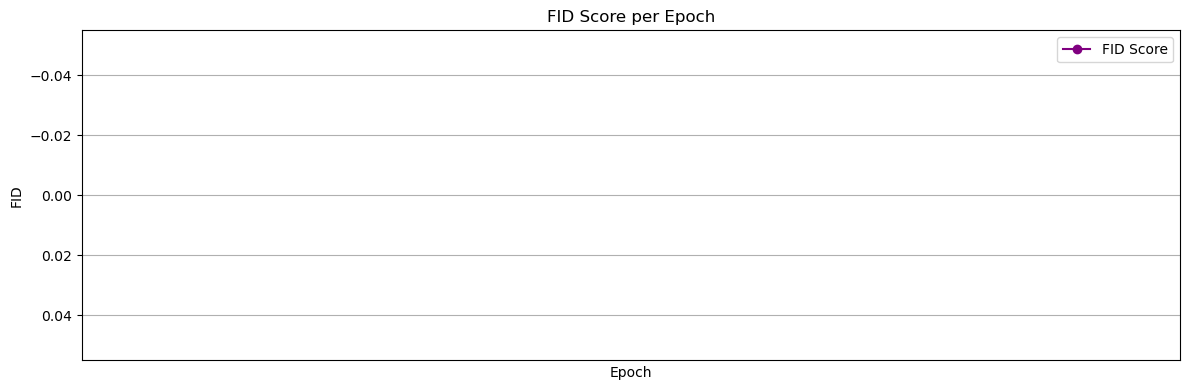

In [ ]:
epochs = list(range(1, len(fid_scores) + 1))

plt.figure(figsize=(12, 4))  # width=12, height=4
plt.plot(epochs, fid_scores, marker='o', color='purple', label='FID Score')
plt.title('FID Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.xticks(epochs)
plt.gca().invert_yaxis()  # Lower FID is better
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()